# Simulating Relax displacements with a basal dislocation

## Getting a sense for the output: Make a single pyGMT plot

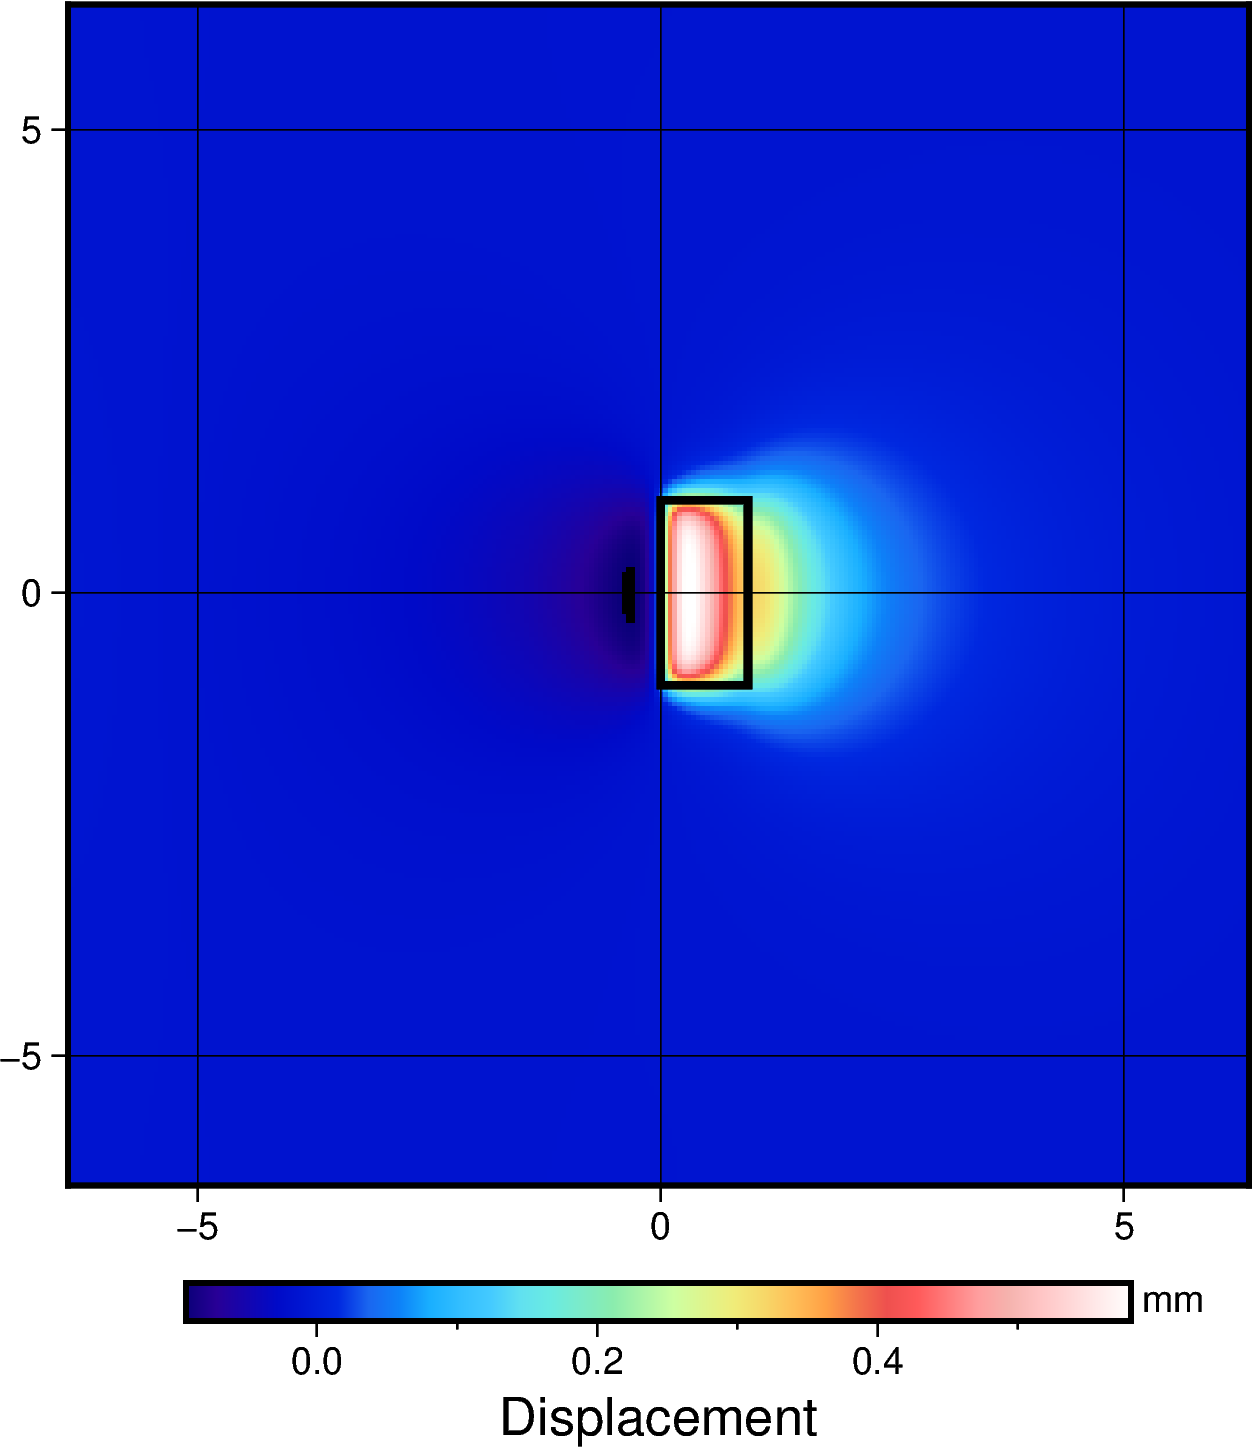

In [63]:
import pygmt

directory = "/Users/jloveles/Documents/relax/examples/tutorials/output2_dipping_linear/"
pathname = directory + "000-east.grd"
faultname = directory + "rfaults-001.xy"
grid = pygmt.load_dataarray(pathname)

# Get z limits from grdinfo
info = pygmt.grdinfo(pathname, nearest_multiple="+a0.1")

fig = pygmt.Figure()
pygmt.makecpt(cmap="haxby", series=info[2:])
fig.grdimage(grid=grid, projection="X10c", frame="ag")
fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

pygmt.makecpt(cmap="gray", series=[0, 2000])
fig.plot(faultname, cmap=True, close=True, pen="2p")

fig.show()

## Set up triangular dislocation sources

In [ ]:
def tri_horizon(x, y, z, el_size):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth 
    # el_size gives nominal element size 

    import gmsh
    import meshio
    
    # Mesh construction using Gmsh
    gmsh.initialize()
    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z+0.01, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z-0.01, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z-0.01, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z+0.01, el_size, 4)
    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri

## Define source mesh and horizon, calculate partials

In [ ]:
import cutde.halfspace as cutde_halfspace
import numpy as np
import pandas as pd
import xarray as xa
import addict
import celeri

# Get stations from grid plotted above
gsubset = 10 # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg = np.array([Xg[0::gsubset, 0::gsubset], Yg[0::gsubset, 0::gsubset], 0*Yg[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()

# Define source fault
meshes = []
meshes.append(addict.Dict())
source_len = 2
source_ldep = 1
source_bdep = 0
source_dip = 20*np.pi/180
# Fault coordinates
meshes[0].coords = np.array([[0.01, -source_len/2, source_bdep], [0.01, source_len/2, source_bdep], [0.01+source_ldep*np.cos(source_dip), source_len/2, -source_ldep*np.sin(source_dip)], [0.01+source_ldep*np.cos(source_dip), -source_len/2, -source_ldep*np.sin(source_dip)]])
meshes[0].verts = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

# Define horizontal mesh
meshes.append(addict.Dict())
meshes[1].coords, meshes[1].verts = tri_horizon([-10, 10], [-10, 10], -2, 1)
nsource_tri = np.shape(meshes[0].verts)[0]
nhoriz_tri = np.shape(meshes[1].verts)[0]
ntri = nsource_tri + nhoriz_tri

# Concatenate source and horizontal
source_tri_pts = meshes[0].coords[meshes[0].verts]
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

# Calculate element normals, strike and dip
meshes[0].normal_vector = np.cross(source_tri_pts[:, 1, :] - source_tri_pts[:, 0, :], source_tri_pts[:, 2, :] - source_tri_pts[:, 0, :])
meshes[1].normal_vector = np.cross(horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :], horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :])

# Calculate TDE partials for the subset array
disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=all_tri_pts, nu=0.25)

# Calculate TDE partials for the full array, for comparison with full Relax grid
obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
disp_mat_full = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=all_tri_pts, nu=0.25)

# Set up inversion of Relax displacements

## Matrix assembly

In [ ]:
# Get triangular smoothing matrix

operators = addict.Dict()
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

# Assemble matrices
assembled_mat = np.zeros((np.size(obsg)+3*ntri, 3*ntri))
# Insert elastic partials
assembled_mat[0:np.size(obsg), :] = disp_mat.reshape((-1, 3*ntri))
# Insert smoothing matrices
source_row_start = np.size(obsg)
source_row_end = np.size(obsg) + 3*nsource_tri
assembled_mat[source_row_start:source_row_end, 0:3*nsource_tri] = operators.smoothing_matrix[0].toarray()
assembled_mat[source_row_end:, 3*nsource_tri:] = operators.smoothing_matrix[1].toarray()

# Assemble weighting vector
smoothing_weight = 1e-3
weights = np.ones((np.shape(assembled_mat)[0], 1))
weights[source_row_start:] = smoothing_weight

## Sequential reading and inversion of modified displacement grids

- Read each time step's displacement grid
- Add cumulative interseismic displacement: backslip rate times elapsed time since earthquake
   - `backslip_rate = 0.001` yields maximum source slip of 0.02, similar to maximum horizon slip. Basal slip estimate looks similar to inversion of unmodified displacements.
   - `backslip_rate = 0.01` yields maximum source slip of 0.2, 10x maximum horizon slip. Basal slip estimate looks similar to inversion of unmodified displacements.
   - `backslip_rate = 0.1` yields maximum source slip of 2, 100x maximum horizon slip. Basal slip estimate looks different from inversion of unmodified displacements: faster slip, more equant concentration (less elongation parallel to strike), more checkerboarding (positive dip-slip surrounded by negative halo). The deviation from the unperturbed displacement estimation begins about half-way through the time sequence. *Need to plot predicted displacements from basal slip only vs. Relax displacements.*
   

In [ ]:
import glob

# Read sequence of displacement grd files and invert
e_disp_file_list = sorted(glob.glob(directory + "*-relax-east.grd"))
n_disp_file_list = sorted(glob.glob(directory + "*-relax-north.grd"))
u_disp_file_list = sorted(glob.glob(directory + "*-relax-up.grd"))

# Read time vector
time_vector = np.loadtxt(directory + "time.txt", unpack=False)

# Unit displacement field
backslip_vec = np.array([[0, -1, 0], [0, -1, 0]])
# Partials from first two elements (source)
unit_inter_disp = disp_mat[:, :, 0:2, :].reshape((-1, 6)).dot(backslip_vec.flatten())

# Define backslip rate 
backslip_rate = 0.01

# Allocate space for estimated slip and predicted displacements
est_slip = np.zeros((3*ntri, len(e_disp_file_list)))
pred_disp = np.zeros((obsg_full.size, len(e_disp_file_list)))
pred_disp_source = np.zeros((obsg_full.size, len(e_disp_file_list)))
pred_disp_horiz = np.zeros((obsg_full.size, len(e_disp_file_list)))

# Allocate space for data vector
data_vector = np.zeros(source_row_start+3*ntri)

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Read each file and invert 
for i in range(len(e_disp_file_list)):
    # Read components
    e_disp = pygmt.load_dataarray(e_disp_file_list[i])
    n_disp = pygmt.load_dataarray(n_disp_file_list[i])
    u_disp = pygmt.load_dataarray(u_disp_file_list[i])
    # Take the same subset as when setting up partials
    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
    data_vector[0:source_row_start] = disp_array.flatten() + backslip_rate*time_vector[i]*unit_inter_disp
    # Estimate slip using pre-calculated covariance
    est_slip[:, i] = cov @ assembled_mat.T * weights.T @ data_vector 
    # Predict displacement at the full grid resolution
    pred_disp[:, i] = disp_mat_full.reshape((-1, 3*ntri)).dot(est_slip[:, i])
    # Predict displacement from source slip
    pred_disp_source[:, i] = disp_mat_full[:, :, 0:nsource_tri, :].reshape((-1, 3*nsource_tri)).dot(est_slip[0:3*nsource_tri, i])
    # Predict displacement from basal horizon slip
    pred_disp_horiz[:, i] = disp_mat_full[:, :, nsource_tri:, :].reshape((-1, 3*nhoriz_tri)).dot(est_slip[3*nsource_tri:, i])


## Plot results

### Displacement grids (pyGMT; north component only)

In [ ]:

# Get z limits from grdinfo
info = pygmt.grdinfo(n_disp_file_list[-1], nearest_multiple="+a0.01")

# Make a time series array for all north displacements
e_disp_array = np.zeros((np.shape(obsg_full)[0], len(e_disp_file_list)))
n_disp_array = np.zeros((np.shape(obsg_full)[0], len(n_disp_file_list)))
u_disp_array = np.zeros((np.shape(obsg_full)[0], len(u_disp_file_list)))

# Displacement field from backslip on source
unit_inter_disp_full = disp_mat_full[:, :, 0:2, :].reshape((-1, 6)).dot(backslip_vec.flatten())

# For all time steps,
for i in range(len(n_disp_file_list)):
    # Convert predicted displacements to xarrays
    eastdispg = xa.DataArray.copy(grid)
    eastdispg.values = np.reshape(pred_disp[0::3, i], (256, 256))
    northdispg = xa.DataArray.copy(grid)
    northdispg.values = np.reshape(pred_disp[1::3, i], (256, 256))
    updispg = xa.DataArray.copy(grid)
    updispg.values = np.reshape(pred_disp[2::3, i], (256, 256))
    # Read in Relax displacements
    e_disp = pygmt.load_dataarray(e_disp_file_list[i])
    n_disp = pygmt.load_dataarray(n_disp_file_list[i])
    u_disp = pygmt.load_dataarray(u_disp_file_list[i])
    # Add to an array for later displacement vs. time plot
    disp_from_backslip = backslip_rate*time_vector[i]*unit_inter_disp_full
    e_disp_array[:, i] = np.array(e_disp).flatten() + disp_from_backslip[0::3]
    n_disp_array[:, i] = np.array(n_disp).flatten() + disp_from_backslip[1::3]
    u_disp_array[:, i] = np.array(u_disp).flatten() + disp_from_backslip[2::3]
    # Residual displacements: Relax - TDE predicted (not currently plotted)
    diffgrid = n_disp - northdispg
    
    # pyGMT figure: 2 panels, TDE and Relax
    # fig = pygmt.Figure()
    # pygmt.makecpt(cmap="haxby", series=info[2:])
    # with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
    #      with fig.set_panel(panel=0):
    #          # TDE predictions
    #          fig.grdimage(grid=northdispg, projection="X10c", frame=["ag", f"+tTDE, step {i}"])
    #          fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
    #      with fig.set_panel(panel=1):
    #          # Relax grid
    #          fig.grdimage(grid=n_disp, projection="X10c", frame=["ag", f"+tRelax, step {i}"])
    #          fig.colorbar(frame=["x+lDisplacement", "y+lmm"])

    # fig.show()
    # fig.savefig(f"png/ndisplacement_{i}.png")

### Basal slip distribution (matplotlib)

In [ ]:
import matplotlib 
from matplotlib import pyplot as plt

# Plot a single mesh; modified from celeri_vis.py
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.coords[:, 0]
    y_coords = mesh.coords[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    pc.set_clim([-0.02, 0.02])
    plt.colorbar(pc, label="Strike-slip (N-S)")

### Plot for each time step

In [ ]:
plt.close("all")
for i in range(len(n_disp_file_list)):
    fig, ax = plt.subplots()
    plot_mesh(meshes[1], est_slip[3*nsource_tri+1::3, i], ax)
    ax.plot([-7, 7, 7, -7, -7], [-7, -7, 7, 7, -7], 'k')
    ax.set_title(f"Time step {i}")
    # fig.savefig(f"png/horizslip_{i}.png")

### Displacement vs. time at selected points

In [ ]:
%matplotlib widget

# Get target coordinates
c1 = [2.5, 0]
c2 = [2.5, 5]
# Coordinate indices
grididx1 = np.where((obsg_full[:, 0]==c1[0]) & (obsg_full[:, 1]==c1[1]))[0]
grididx2 = np.where((obsg_full[:, 0]==c2[0]) & (obsg_full[:, 1]==c2[1]))[0]
# TOTAL observed and predicted displacements
tobsdisp1 = e_disp_array[grididx1, :]
tobsdisp2 = e_disp_array[grididx2, :]
tpreddisp1 = pred_disp[3*grididx1, :]
tpreddisp2 = pred_disp[3*grididx2, :]
print((tpreddisp1[0, -1]-tobsdisp1[0, -1])/tobsdisp1[0, -1])
print((tpreddisp2[0, -1]-tobsdisp2[0, -1])/tobsdisp2[0, -1])

# Find element centroid nearest target coordinates
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
dist1 = np.sqrt((horiz_centroids[:, 0] - c1[0])**2 + (horiz_centroids[:, 1] - c1[1])**2)
dist2 = np.sqrt((horiz_centroids[:, 0] - c2[0])**2 + (horiz_centroids[:, 1] - c2[1])**2)
el_idx1 = np.argmin(dist1)
el_idx2 = np.argmin(dist2)
slip1 = est_slip[3*(nsource_tri+el_idx1)+1, :]
slip2 = est_slip[3*(nsource_tri+el_idx2)+1, :]

# Set up figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(5, 7))
ax1.plot(time_vector, tobsdisp1[0, :], 'b', label="(2.5, 0) Relax")
ax1.plot(time_vector, tpreddisp1[0, :], 'b--', label="(2.5, 0) TDE")
ax1.plot(time_vector, tobsdisp2[0, :], 'r', label="(2.5, 5) Relax")
ax1.plot(time_vector, tpreddisp2[0, :], 'r--', label="(2.5, 5) TDE")
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('East displacement')
ax1.set_title("Total displacement")
# axr = ax1.twinx()
# axr.plot(time_vector, slip1, 'b--', linewidth=3)
# axr.plot(time_vector, slip2, 'r--', linewidth=3)
# axr.set_ylabel('Dip-slip')

# fig.savefig(f"png/timeseries.png")


#
# Basal displacements only
#
# Observed and predicted displacements
bobsdisp1 = e_disp_array[grididx1, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx1]
bobsdisp2 = e_disp_array[grididx2, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx2]
bpreddisp1 = pred_disp_horiz[3*grididx1, :]
bpreddisp2 = pred_disp_horiz[3*grididx2, :]
print((bpreddisp1[0, -1]-bobsdisp1[0, -1])/bobsdisp1[0, -1])
print((bpreddisp2[0, -1]-bobsdisp2[0, -1])/bobsdisp2[0, -1])
ax2.plot(time_vector, bobsdisp1[0, :], 'b', label="(2.5, 0) Relax")
ax2.plot(time_vector, bpreddisp1[0, :], 'b--', label="(2.5, 0) TDE")
ax2.plot(time_vector, bobsdisp2[0, :], 'r', label="(2.5, 5) Relax")
ax2.plot(time_vector, bpreddisp2[0, :], 'r--', label="(2.5, 5) TDE")
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('East displacement')
ax2.set_title("Displacement from basal slip")


#
# Source displacements only
#
# Observed and predicted displacements
sobsdisp1 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx1]
sobsdisp2 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx2]
spreddisp1 = pred_disp_source[3*grididx1, :]
spreddisp2 = pred_disp_source[3*grididx2, :]
print((spreddisp1[0, -1]-sobsdisp1[-1])/sobsdisp1[-1])
print((spreddisp2[0, -1]-sobsdisp2[-1])/sobsdisp2[-1])
ax3.plot(time_vector, sobsdisp1, 'b', label="(2.5, 0) Prescribed")
ax3.plot(time_vector, spreddisp1[0, :], 'b--', label="(2.5, 0) Estimated")
ax3.plot(time_vector, sobsdisp2, 'r', label="(2.5, 5) Prescribed")
ax3.plot(time_vector, spreddisp2[0, :], 'r--', label="(2.5, 5) Estimated")
ax3.legend()
ax3.set_xlabel('Time')
ax3.set_ylabel('East displacement')
ax3.set_title("Displacement from source backslip")
fig.show()



In [ ]:
print((tpreddisp1[0, -1]-tobsdisp1[-1])/tobsdisp1[-1])
print((tpreddisp2[0, -1]-tobsdisp2[-1])/tobsdisp2[-1])

### Prescribed vs. estimated source slip rate

In [ ]:
fig, ax = plt.subplots()
ax.plot(time_vector, backslip_rate*time_vector, linewidth=6)
ax.plot(time_vector, -est_slip[1, :])
ax.plot(time_vector, -est_slip[4, :])
plt.show()
print(backslip_rate*time_vector)
print(-est_slip[1, :])
print(-est_slip[4, :])

## Proposal time-series figure

In [ ]:
# Set up figure
fig, ax1 = plt.subplots(figsize=(8,4))
incr = 5 
# Plot total displacements of nearfield point
ax1.plot(time_vector, tobsdisp1[0, :], 'b', label="Total, Relax")
ax1.plot(time_vector[0::incr], tpreddisp1[0, 0::incr], '.b', label="Total, TDE")
ax1.plot(time_vector, bobsdisp1[0, :], 'r', label="Viscous, Relax")
ax1.plot(time_vector[0::incr], bpreddisp1[0, 0::incr], '.r', linewidth=3, label="Viscous, TDE")
ax1.plot(time_vector, sobsdisp1, 'g', label="Fault, prescribed")
ax1.plot(time_vector[0::incr], spreddisp1[0, 0::incr], '.g', label="Fault, estimated")
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('East displacement')
ax1.autoscale(enable=True, axis='x', tight=True)
fig.show()


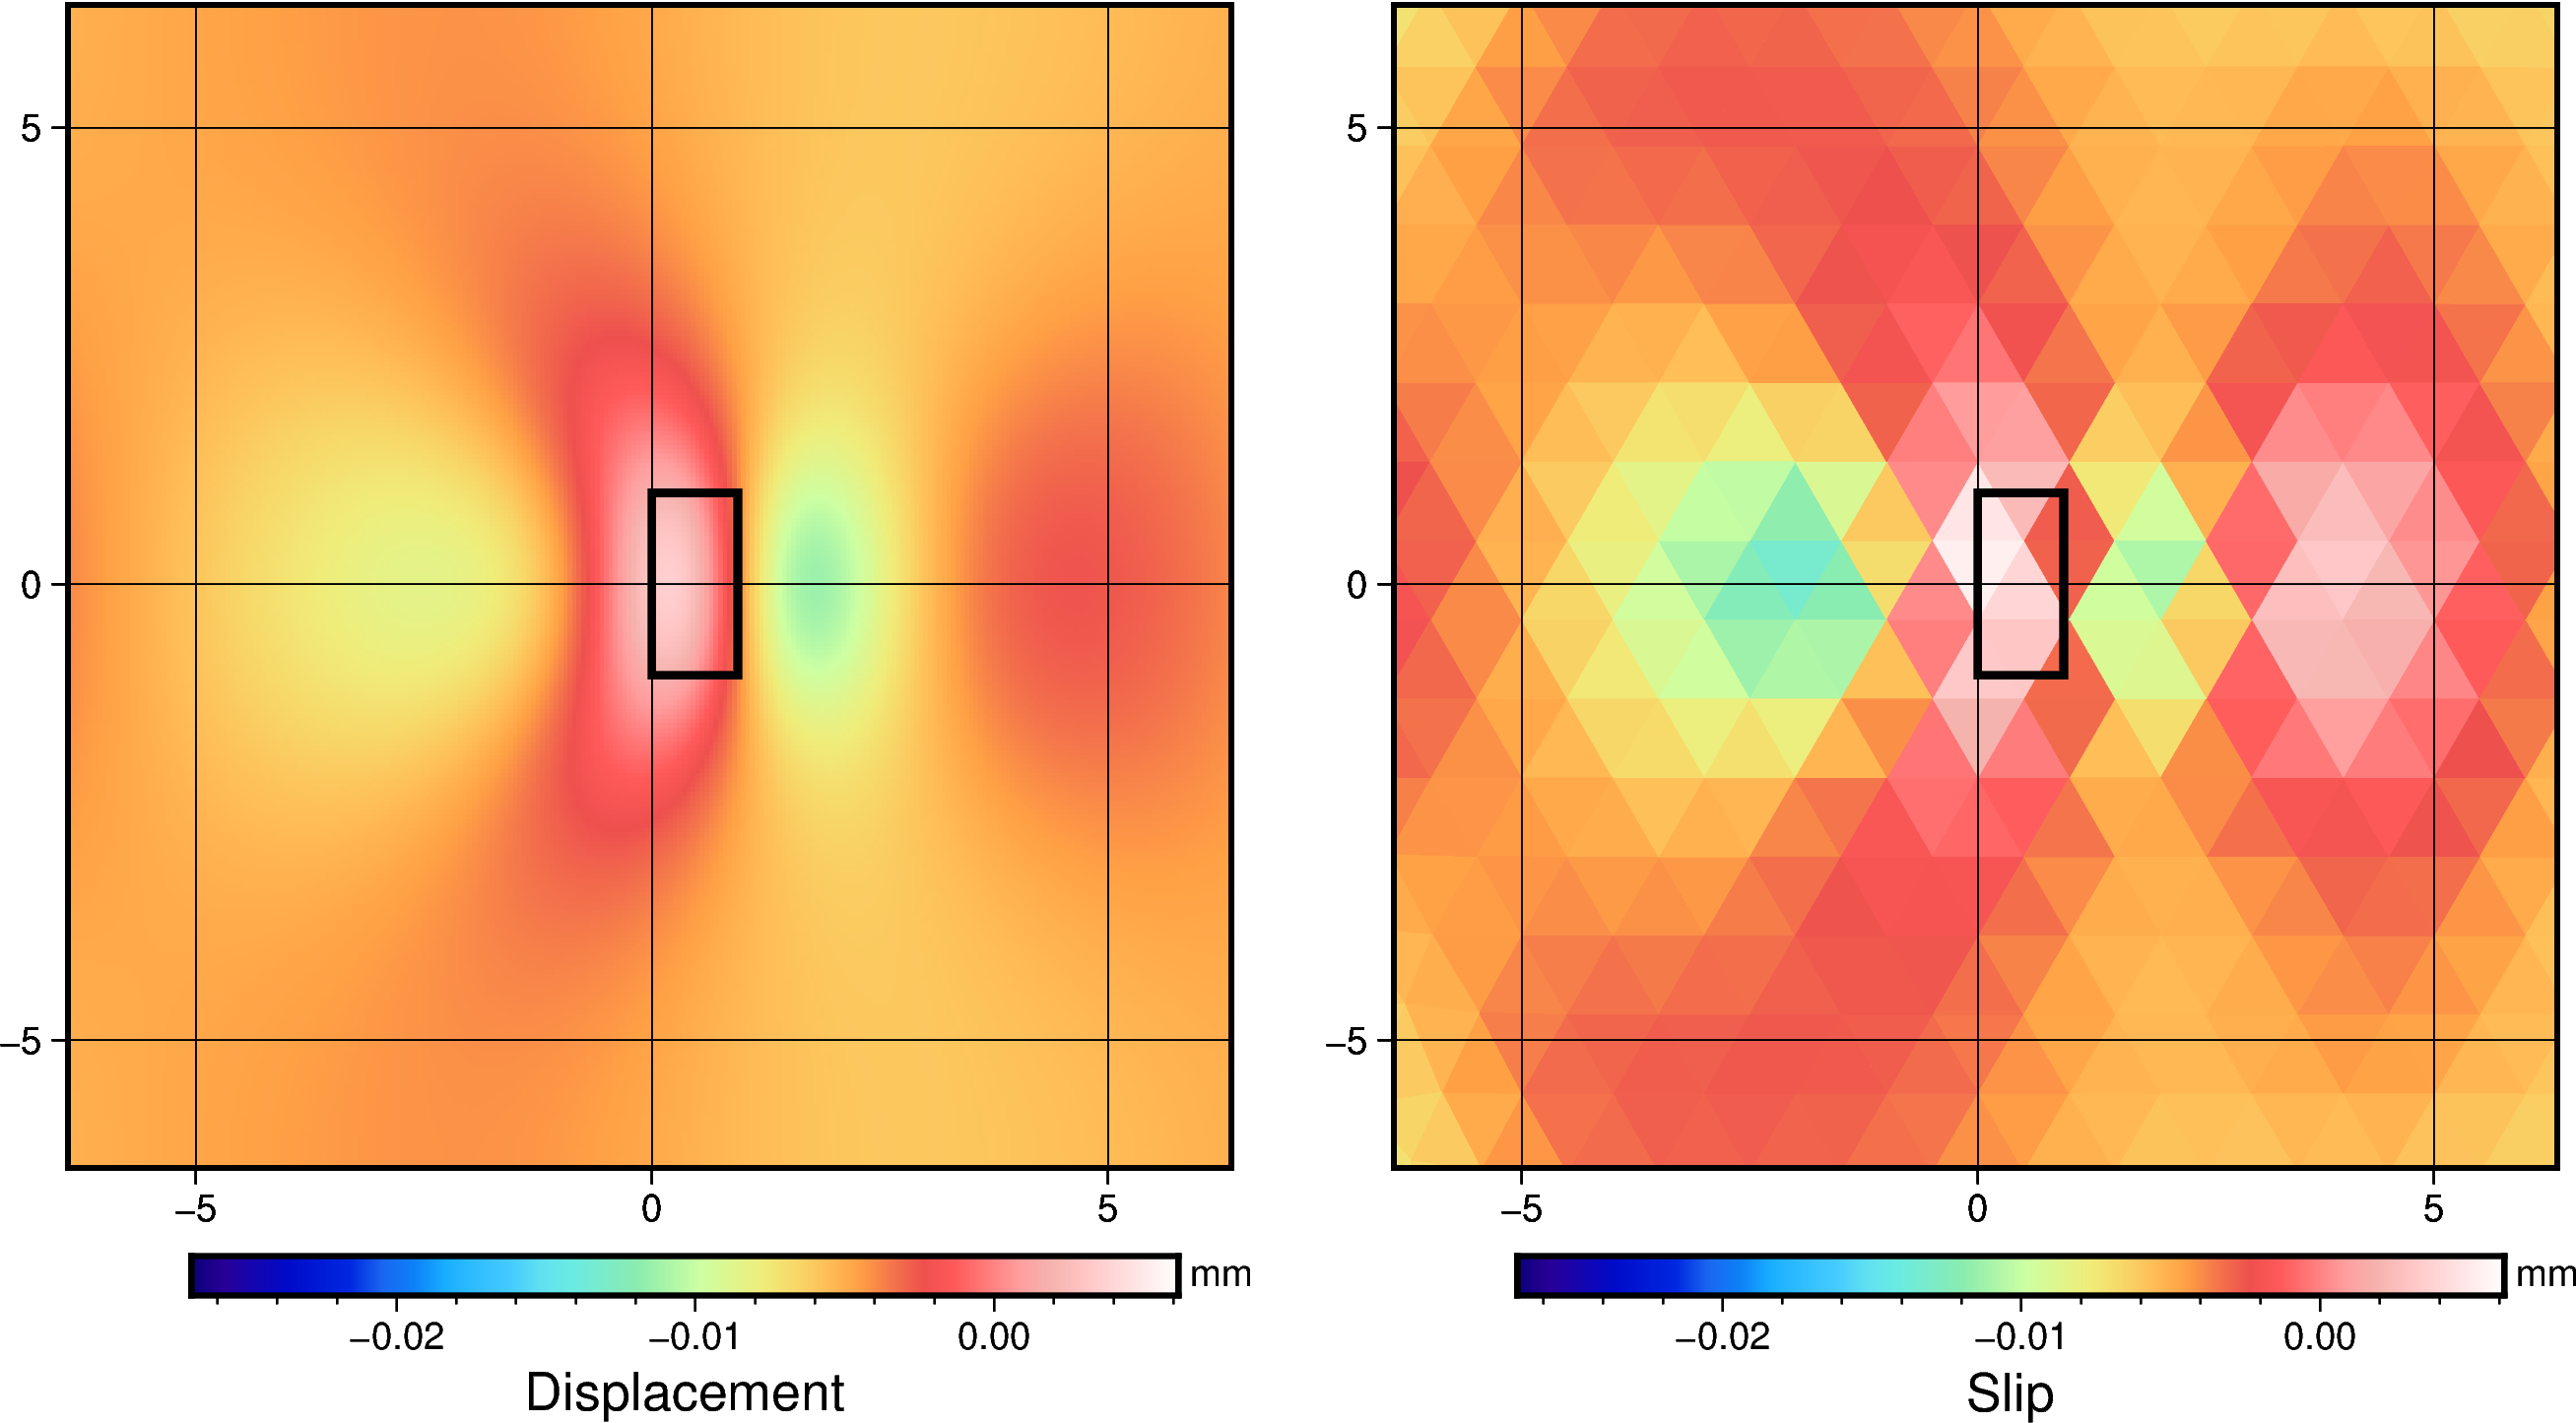

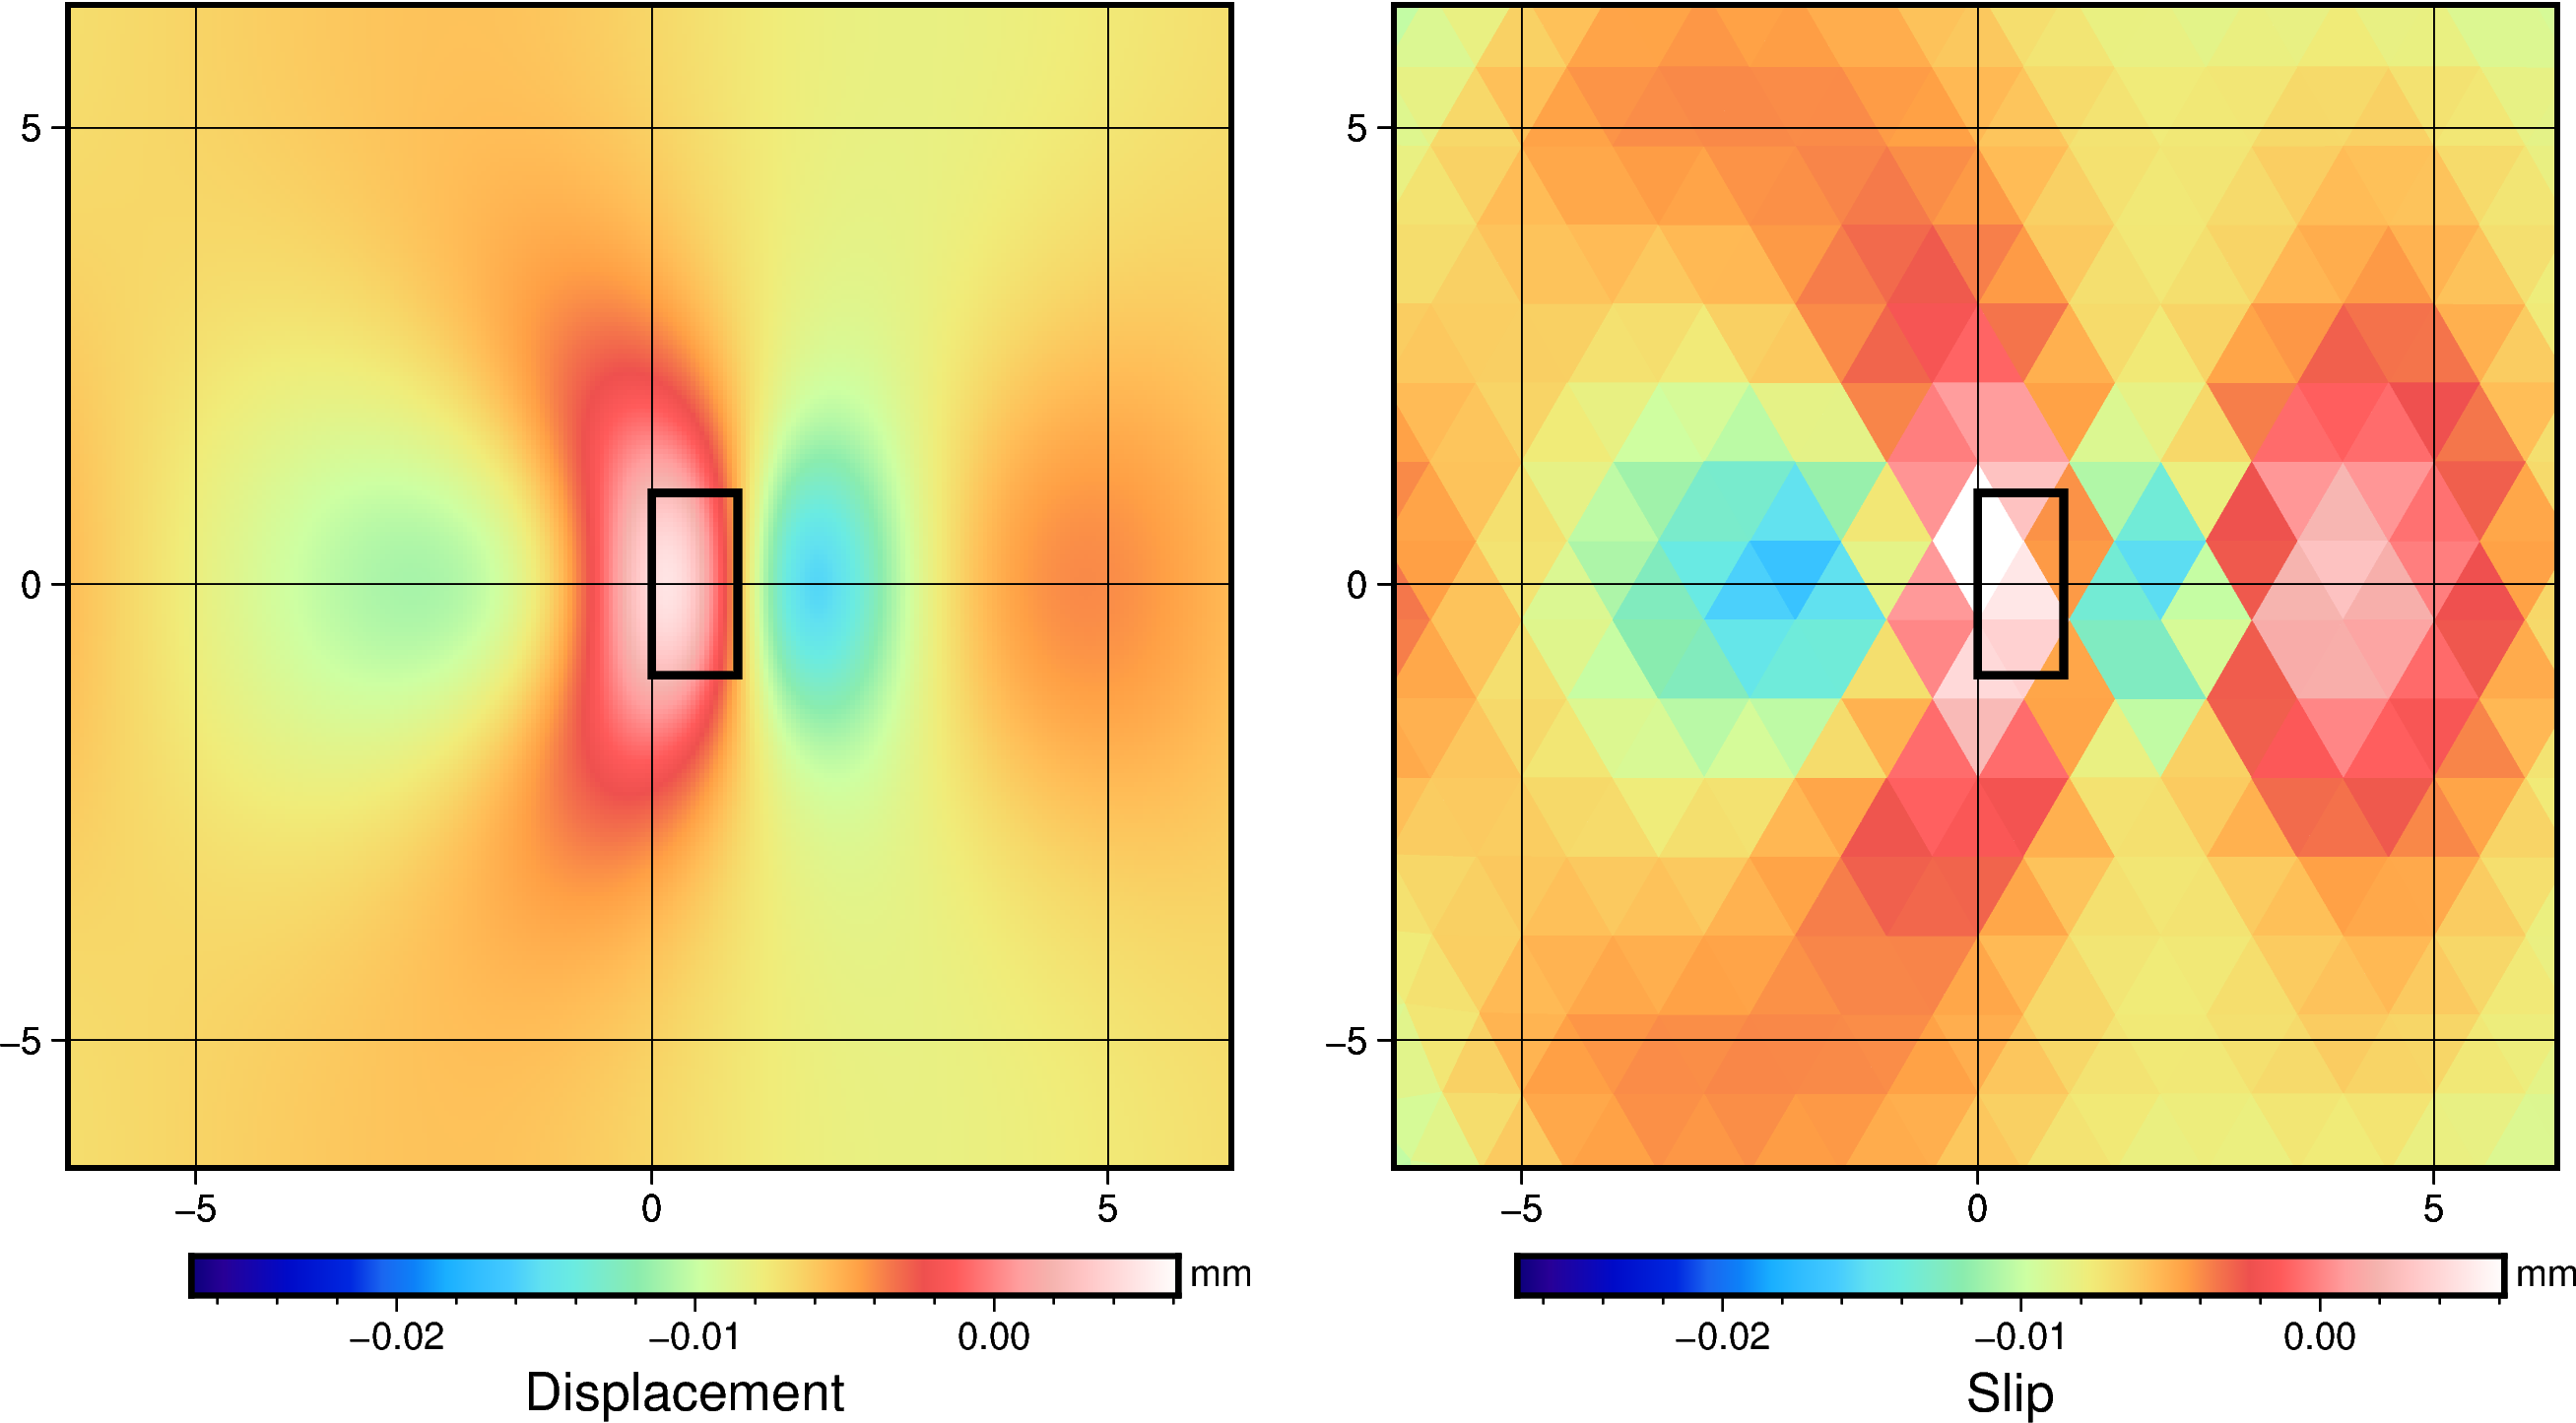

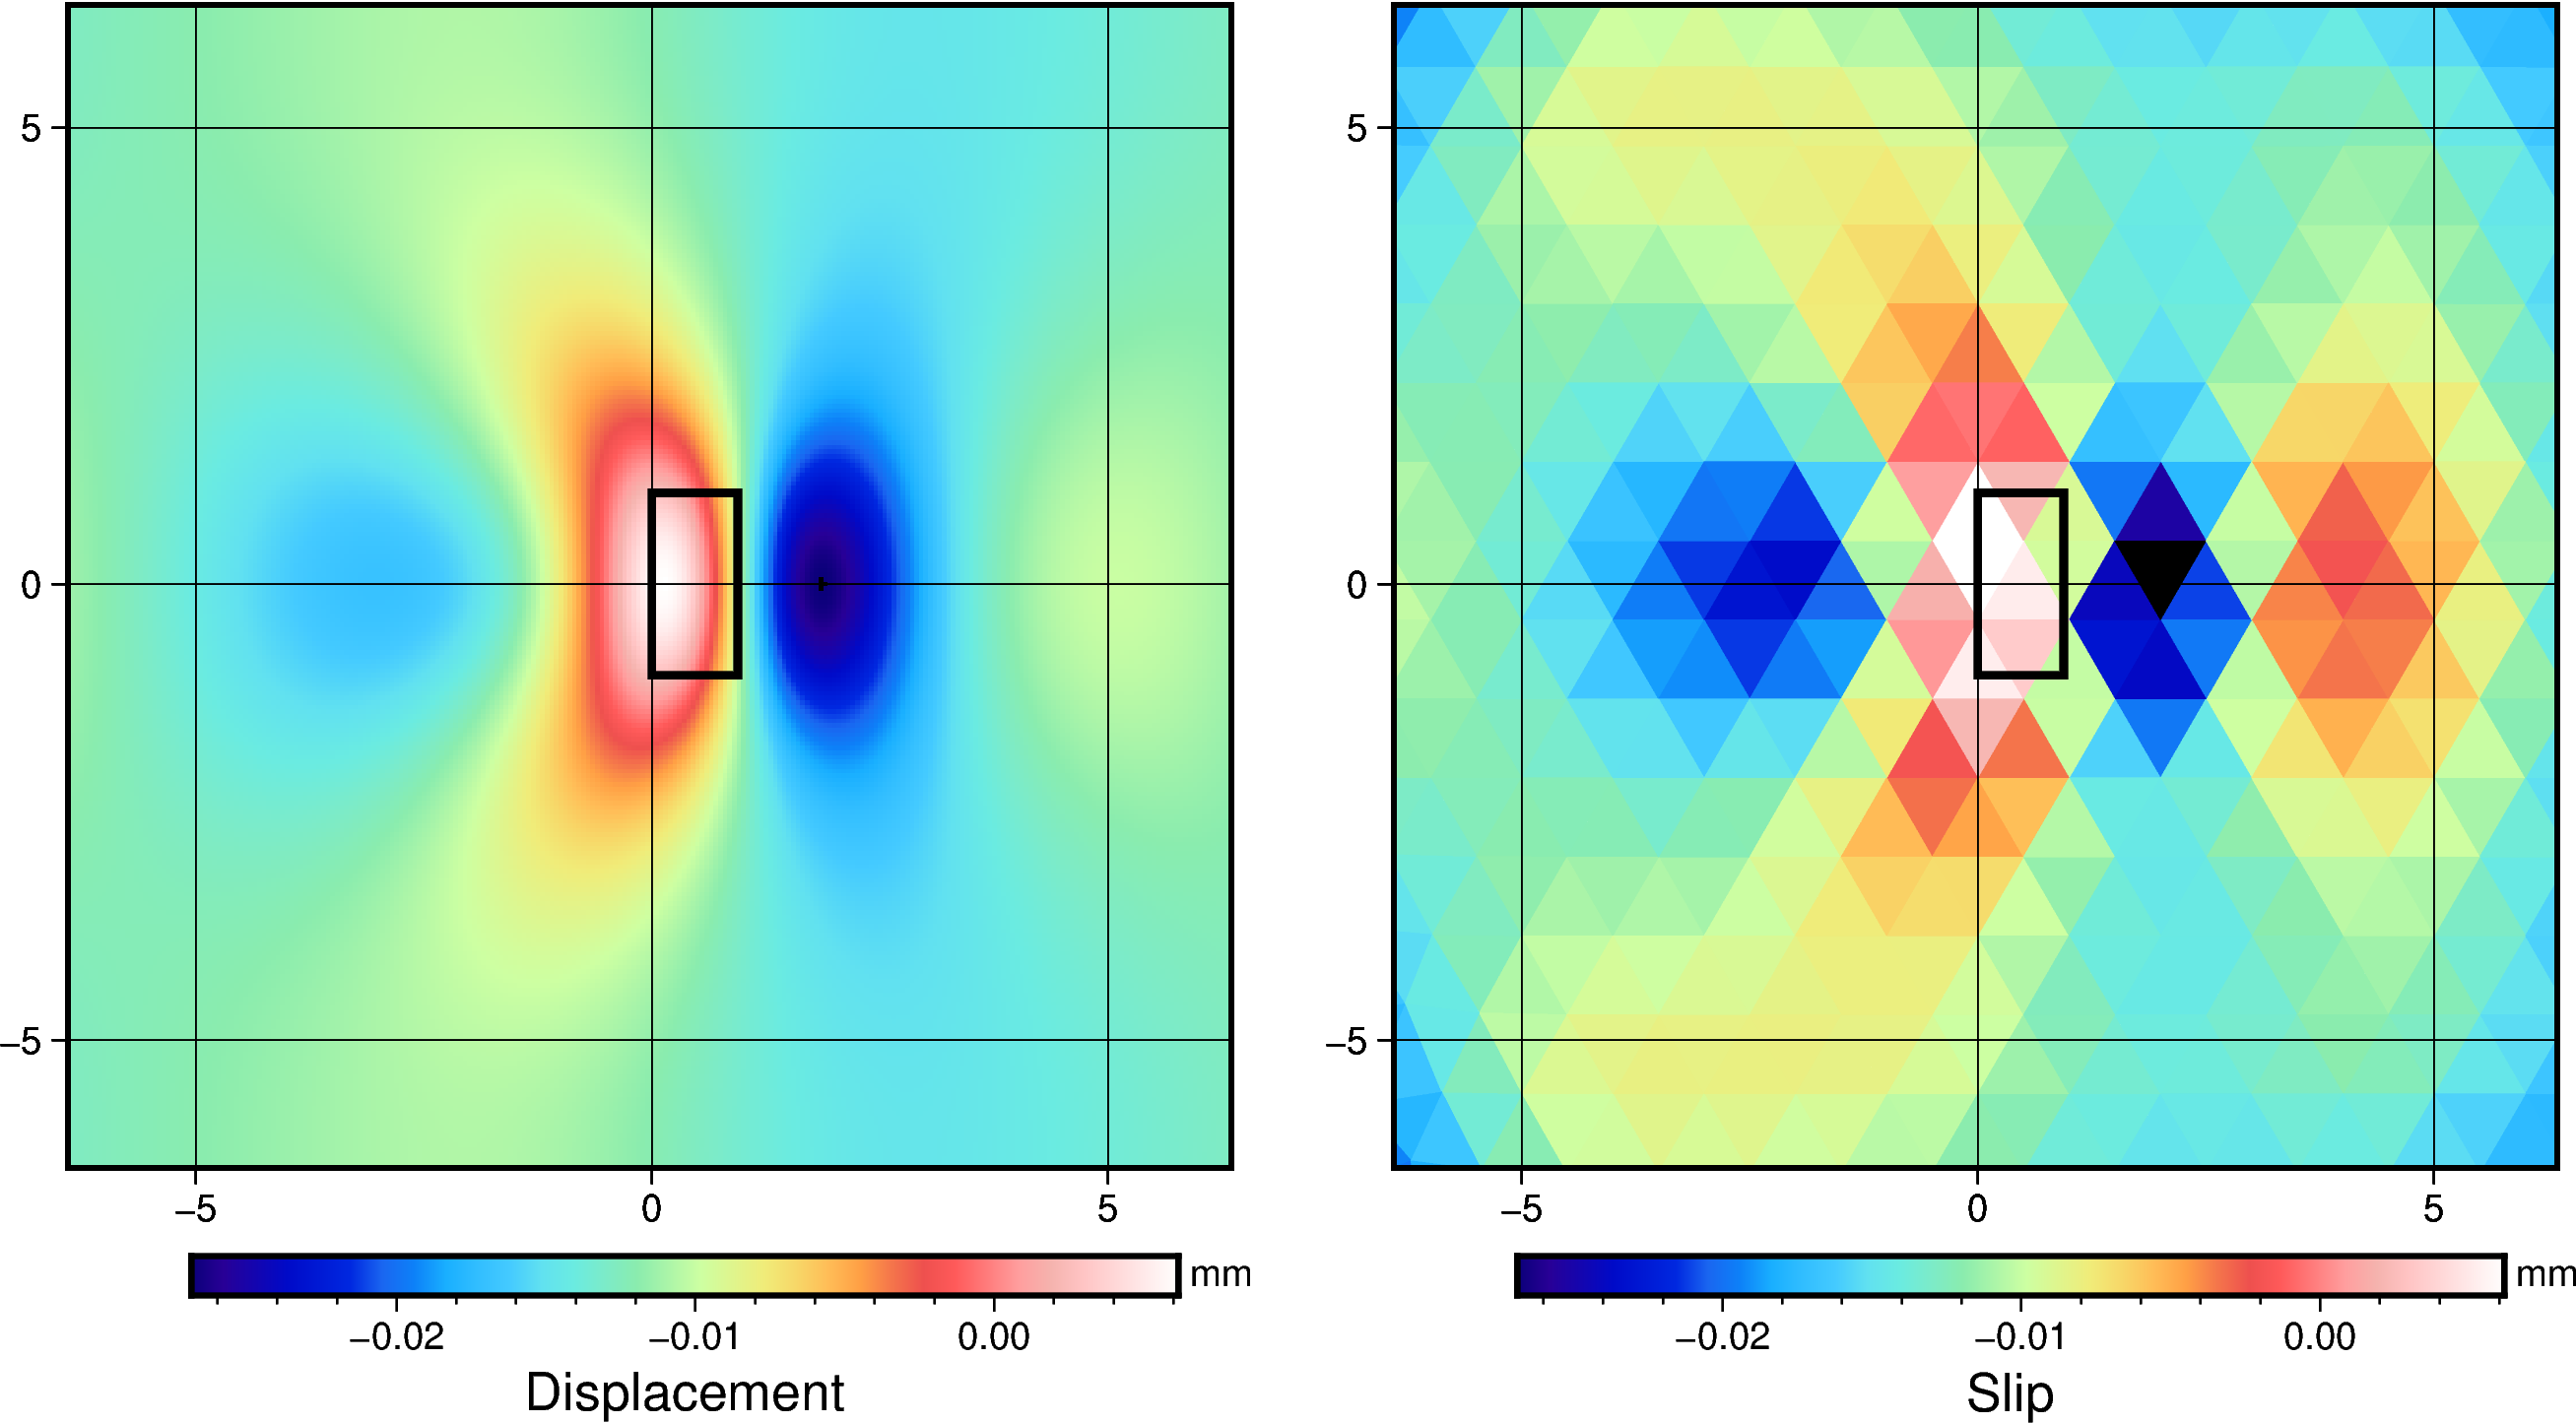

In [75]:
import pandas as pd 

other_depth1 = 2
other_directory1 = directory[:-1] + "_" + str(other_depth1) + "km"

# Read sequence of displacement grd files 
e_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-east.grd"))
n_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-north.grd"))
u_disp_file_list1 = sorted(glob.glob(other_directory1 + "/*-relax-up.grd"))

sel_times = [20, 30, 70]

# Get z limits from grdinfo
info1 = pygmt.grdinfo(e_disp_file_list1[sel_times[-1]], nearest_multiple="+a0.01")

# Predict displacements at each step 
for i in sel_times:
    
    # Read Relax displacement components
    e_disp1 = pygmt.load_dataarray(e_disp_file_list1[i])
    n_disp1 = pygmt.load_dataarray(n_disp_file_list1[i])
    u_disp1 = pygmt.load_dataarray(u_disp_file_list1[i])

    # Write mesh slip file
    fid = open("meshes.txt", "w")
    for j in range(len(meshes[1].verts)):
      line = "> -Z{}\n{}, {}\n{}, {}\n{}, {}\n".format(-est_slip[3*nsource_tri+3*j+1, i],
         meshes[1].coords[meshes[1].verts[j, 0], 0],
         meshes[1].coords[meshes[1].verts[j, 0], 1],
         meshes[1].coords[meshes[1].verts[j, 1], 0],
         meshes[1].coords[meshes[1].verts[j, 1], 1],
         meshes[1].coords[meshes[1].verts[j, 2], 0],
         meshes[1].coords[meshes[1].verts[j, 2], 1])
      fid.write(line)
    fid.close()

    # pyGMT figure: 2 panels, TDE and Relax
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="haxby", series=info1[2:])
    with fig.subplot(nrows=1, ncols=2, figsize=("22c", "6c")):
         with fig.set_panel(panel=0):
            # Relax grid
            fig.grdimage(grid=e_disp1, projection="X10c", frame=["ag"])
            fig.colorbar(frame=["x+lDisplacement", "y+lmm"])
            fig.plot(faultname, close=True, pen="2p", projection="X10c", frame=["ag"])
            
         with fig.set_panel(panel=1):
             # TDE estimated slip
             fig.plot("meshes.txt", close=True, cmap=True, region=[min(xg), max(xg), min(yg), max(yg)], projection="X10c", frame=["ag"])
             fig.colorbar(frame=["x+lSlip", "y+lmm"])
             fig.plot(faultname, close=True, pen="2p", projection="X10c", frame=["ag"])
         #    

    fig.show()